In [11]:
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from tqdm import tqdm

#### **Loading data**

In [12]:
data_path = '../DATA/DatasetExos.csv'

In [13]:
def load_data(path):
    try:
        data = pd.read_csv(path , sep=',')
        return data
    except Exception as e:
      print(f"Une erreur s'est produite : {e}")

In [14]:
data = load_data(data_path)

In [15]:
data.head()

,ep (ms),Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,ID,Exercise,Category,Set
0,2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30.0
1,2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30.0
2,2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30.0
3,2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30.0
4,2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30.0


In [16]:
len(data)

9009

#### **Supperssion des colonnes inutiles**

In [17]:
#### **Supperssion des colonnes inutiles**
data = data.drop(columns=['ep (ms)','ID','Exercise'])


In [18]:
data.head()

,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Category,Set
0,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,heavy,30.0
1,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,heavy,30.0
2,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,heavy,30.0
3,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,heavy,30.0
4,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,heavy,30.0


#### **suppression des valeurs nulle**

In [19]:
data = data.dropna().reset_index(drop=True)

#### **Outlier traitement**

In [20]:
for col in ["Acc_x","Acc_y","Acc_z","Gyro_x","Gyro_y","Gyro_z",'Set']:
    m = data[col].mean()
    s = data[col].std()
    remove = (data[col] < m - 3 * s) | (data[col] > m + 3 * s)
    data = data[~remove]
    
data = data.reset_index(drop=True)

In [21]:
data = data.replace({'heav': 'heavy', 'raw': 'row' , 'reste':'rest'})

#### **Normalisation**

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Liste des colonnes à normaliser
columns_to_normalize = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyro_x', 'Gyro_y', 'Gyro_z', 'Set']

# Initialiser le scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normaliser les colonnes spécifiées
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [23]:
data.head()

,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Category,Set
0,0.386752,0.791869,0.328671,0.479847,0.545385,0.465095,heavy,0.263636
1,0.379939,0.789829,0.323576,0.481404,0.509778,0.468468,heavy,0.263636
2,0.381226,0.790195,0.332667,0.513207,0.516563,0.458652,heavy,0.263636
3,0.369720,0.785591,0.327173,0.554430,0.470917,0.456850,heavy,0.263636
4,0.367903,0.785800,0.302298,0.512294,0.502740,0.452642,heavy,0.263636


#### **Changement de type de "category" vers type categoty**

In [24]:
data["Category"] = data["Category"].astype("category")

In [25]:
data.dtypes

Acc_x        float64
Acc_y        float64
Acc_z        float64
Gyro_x       float64
Gyro_y       float64
Gyro_z       float64
Category    category
Set          float64
dtype: object

#### **verfier si une valeur est numerique**

In [26]:
def is_numeric(value):
    return isinstance(value, (int, float, np.number))


#### **Calcule de la distance entre deux instance**

In [27]:

def combined_distance(instance1, instance2, alpha=1):
    # print(f"instance 1: {instance1}")
    # print(f"instance 2: {instance2}")
    """
    Calcule la distance combinée (Manhattan + Hamming) entre deux instances.
    """
    manhattan_distance = 0
    hamming_distance = 0

    for val1, val2 in zip(instance1, instance2):
        if is_numeric(val1) and is_numeric(val2):
            manhattan_distance += abs(val1 - val2)
        else:
            hamming_distance += alpha if val1 != val2 else 0

    return manhattan_distance + hamming_distance


#### **Calcule le centroid d'un cluster**
* Moyenne pour les colonnes numériques.
* Valeur la plus fréquente pour les colonnes catégoriques.

In [28]:
def calculate_centroid(cluster):
    """
    Calcule le centroïde d'un cluster.
    - Moyenne pour les colonnes numériques.
    - Valeur la plus fréquente pour les colonnes catégoriques.
    """
    centroid = []
    for col in cluster.columns:
        if cluster[col].dtype in [np.float64, np.int64]:
            centroid.append(cluster[col].mean())
        else:
            centroid.append(cluster[col].mode().iloc[0])
    return centroid


#### **Assigne une instance au cluster le plus proche.**

In [29]:

def assign_to_cluster(instance, centroids):
    """
    Assigne une instance au cluster le plus proche.
    """
    distances = [combined_distance(instance, centroid) for centroid in centroids]
    # print(f"la distance entre chaque centroid et l'instance {distances}")
    return np.argmin(distances)

#### **L'algorithme K-means**

In [30]:
centroids = data.sample(n=2 , replace=False).to_numpy()

In [31]:
def k_means(data, k, max_iter=100, epsilon=1e-1):
    """
    Implémente l'algorithme k-means.
    """
    # Initialiser aléatoirement les centroïdes
    centroids = data.sample(n=k , replace=False).to_numpy().tolist()
    
    # print(f"centroids : {centroids}")
    clusters = None

    for _ in tqdm(range(max_iter)):
        
        # Étape 1 : Assignation des clusters
        # assign_to_cluster(row.to_numpy(), centroids): Fonction externe qui calcule la distance entre le point et chaque centroïde, puis retourne l'index du cluster le plus proche.
        clusters = data.apply(lambda row: assign_to_cluster(row, centroids), axis=1)
        
        
        # Étape 2 : Recalcul des centroïdes
        new_centroids = []
        
        for i in range(k):
            cluster_points = data[clusters == i]
            
            
            if not cluster_points.empty:
                new_centroids.append(calculate_centroid(cluster_points))
            else:
                new_centroids.append(data.sample(n=1).to_numpy().tolist()[0])
                
        
        # new_centroids = np.array(new_centroids)

        # Vérifier la convergence
        if np.array([combined_distance(x, y) for x,y in zip(new_centroids, centroids)]).mean()<epsilon :
            break

        centroids = new_centroids

    return clusters, centroids

#### **k-means avec k=2**

In [32]:
# Appliquer k-means avec k=2
clusters, centroids = k_means(data, 
                              k=2, 
                              max_iter=20, 
                              epsilon=0)

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


<Axes: ylabel='Frequency'>

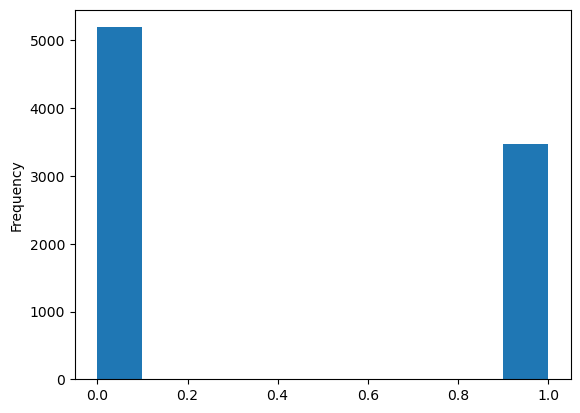

In [33]:
clusters.plot.hist()

In [34]:
print("Clusters assignés :", clusters)

Clusters assignés : 0       1
1       1
2       1
3       1
4       1
       ..
8663    0
8664    0
8665    0
8666    0
8667    0
Length: 8668, dtype: int64


In [35]:
print("Centroïdes finaux :", centroids)

Centroïdes finaux : [[0.41472558886294236, 0.42129628258549706, 0.4279845876110796, 0.4961470260454468, 0.5045823378930517, 0.4632128781566831, 'medium', 0.38928833969265236], [0.36381319955704206, 0.646066115106529, 0.4362061369833389, 0.4999696546557937, 0.4944955186452108, 0.4654980338013307, 'heavy', 0.43571989323284654]]


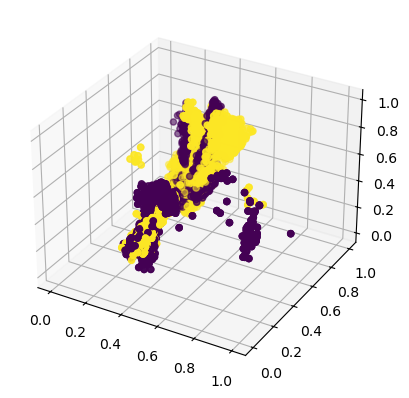

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Acc_x, data.Acc_y, data.Acc_z,c=clusters, cmap='viridis')

#### **k-means avec k=5**

In [37]:
# Appliquer k-means avec k=5
clusters, centroids = k_means(data,
                              k=5, 
                              max_iter = 20, 
                              epsilon = 0)

100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


<Axes: ylabel='Frequency'>

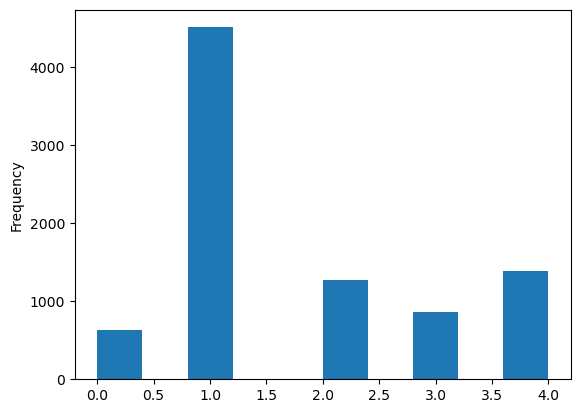

In [38]:
clusters.plot.hist()

In [39]:
np.unique(clusters)

array([0, 1, 2, 3, 4], dtype=int64)

In [40]:
print("Clusters assignés :", clusters)

Clusters assignés : 0       2
1       2
2       2
3       2
4       2
       ..
8663    1
8664    1
8665    1
8666    1
8667    1
Length: 8668, dtype: int64


In [41]:
print("Centroïdes finaux :", centroids)

Centroïdes finaux : [[0.5277964483574972, 0.2712260071762275, 0.6273632418536876, 0.4951539329210478, 0.5337671451819529, 0.4602131476704836, 'standing', 0.39500579038795597], [0.3893466862359802, 0.4445455369391373, 0.40266411336890046, 0.49667427783500534, 0.4992078644455841, 0.46386742149511134, 'medium', 0.37962403288201163], [0.33230664652747444, 0.5830037845644277, 0.33397889394749664, 0.4988996142863978, 0.4938865197510001, 0.46542117710824477, 'heavy', 0.24104466961609816], [0.4850486794515932, 0.6679855164508934, 0.7984375578125578, 0.501137319781657, 0.497805957836071, 0.46323531136445384, 'heavy', 0.35428240740740735], [0.35060620088335037, 0.6738423544636274, 0.2965383537325982, 0.4988132871914341, 0.49764796367200875, 0.46611676790923523, 'heavy', 0.6917527795945063]]


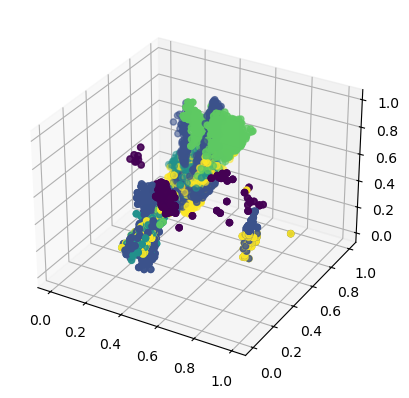

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Acc_x, data.Acc_y, data.Acc_z,c=clusters, cmap='viridis')

#### **K-means avec k = 6**

In [43]:
# Appliquer k-means avec k=6
clusters, centroids = k_means(data,
                              k=6, 
                              max_iter=20, 
                              epsilon=0)

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


<Axes: ylabel='Frequency'>

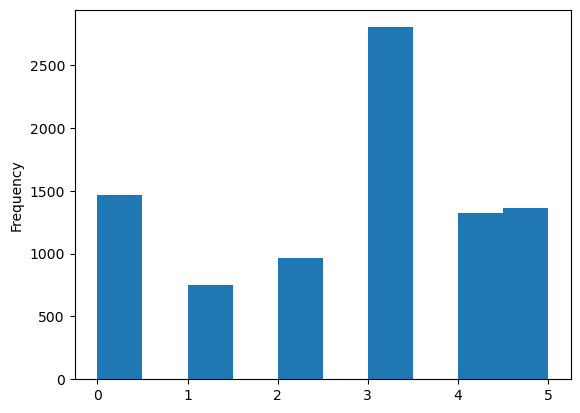

In [44]:
clusters.plot.hist()

In [49]:
print("Clusters assignés :", clusters)

Clusters assignés : 0       5
1       5
2       5
3       5
4       5
       ..
8663    3
8664    3
8665    3
8666    3
8667    3
Length: 8668, dtype: int64


In [50]:
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [51]:
print("Centroïdes finaux :", centroids)

Centroïdes finaux : [[0.3883563005682171, 0.6506807057142978, 0.30275722909101827, 0.49878082078689917, 0.5003936158882019, 0.4656006991696061, 'heavy', 0.6991605521701281], [0.40585354286183284, 0.7258481947462323, 0.7141450249883985, 0.5020017985464478, 0.49930290309821523, 0.46373635091721116, 'medium', 0.22954849701837649], [0.5146265664003596, 0.629315082590578, 0.7931337257783538, 0.501934199523861, 0.497699923406657, 0.46371991089470954, 'heavy', 0.3965627347858752], [0.4175335784578777, 0.17457713897048385, 0.4130161980876265, 0.4948034309199251, 0.5089218811107513, 0.4629813165065655, 'medium', 0.35340584415584414], [0.32017525230554533, 0.7778397257747622, 0.2820458576114683, 0.49521876538980564, 0.4930490348286523, 0.4640620928100032, 'medium', 0.4770739064856711], [0.3334925533714325, 0.593211953814685, 0.33995828347476686, 0.4994046413390953, 0.493469264905872, 0.4654752287325914, 'heavy', 0.24615384615384617]]


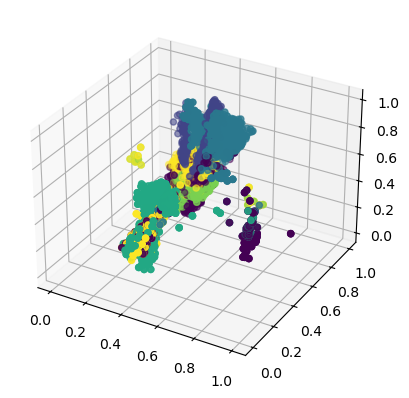

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Acc_x, data.Acc_y, data.Acc_z,c=clusters, cmap='viridis')

#### **visualisation de k-means avec 3 attribut**

In [60]:
clusters, centroids = k_means(data[["Acc_x", "Acc_y", "Acc_z"]], 
                              k=6, max_iter=20, epsilon=0)


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


<Axes: ylabel='Frequency'>

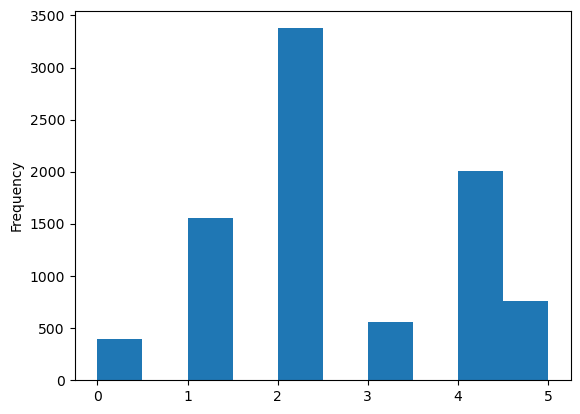

In [61]:
clusters.plot.hist()

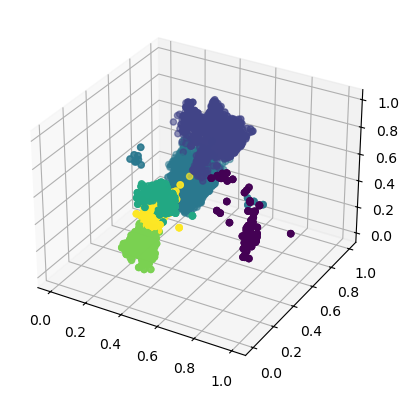

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Acc_x, data.Acc_y, data.Acc_z,c=clusters, cmap='viridis')

In [63]:
print("Clusters assignés :", clusters)

Clusters assignés : 0       2
1       2
2       2
3       2
4       2
       ..
8663    4
8664    4
8665    4
8666    4
8667    4
Length: 8668, dtype: int64


In [64]:
print("Centroïdes finaux :", centroids)

Centroïdes finaux : [[0.7829622481233846, 0.40618371333527437, 0.48251443213275264], [0.4562255313928011, 0.6956648769466519, 0.7670723254964125], [0.30440596841482515, 0.776018647942374, 0.2924806611806906], [0.4705070301711786, 0.20017779646319606, 0.6186408618024958], [0.3942368727554162, 0.13198415949448639, 0.3273465708010256], [0.40941601975132663, 0.2465519652811333, 0.4675329898859309]]


#### **K-means (sklearn)**

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Identifier les colonnes catégoriques
categorical_columns = ['Category']  # Remplacez par vos colonnes catégoriques

# Transformation des données
encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_columns)
], remainder='passthrough')  # Reste des colonnes laissé inchangé (numériques)

# Encoder les données
encoded_data = encoder.fit_transform(data)


In [66]:
from sklearn.cluster import KMeans

# Initialiser K-means avec k=2
kmeans = KMeans(n_clusters=7, max_iter=20, tol=0)

# Ajuster K-means aux données transformées
kmeans.fit(encoded_data)

# Obtenir les clusters et les centroïdes
clusters = kmeans.labels_  # Cluster de chaque échantillon
centroids = kmeans.cluster_centers_  # Coordonnées des centroïdes

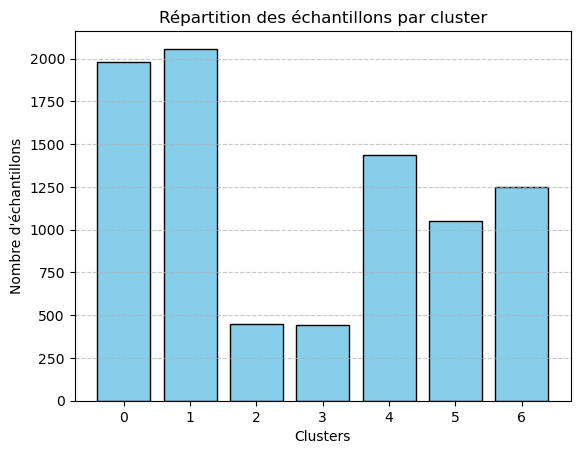

In [67]:
import matplotlib.pyplot as plt
import numpy as np


# Créer un histogramme
unique_clusters, counts = np.unique(clusters, return_counts=True)  # Comptage des échantillons dans chaque cluster

plt.bar(unique_clusters, counts, color='skyblue', edgecolor='black')
plt.title("Répartition des échantillons par cluster")
plt.xlabel("Clusters")
plt.ylabel("Nombre d'échantillons")
plt.xticks(unique_clusters)  # S'assurer que les clusters sont affichés correctement
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

